In [1]:
import pandas as pd
import os
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import numpy as np

In [2]:
apparel_list = ['T-Shirt','Shirt', 'Dress', 'Pants', 'Shorts','Skirt']

In [18]:
IMG_SIZE = 224

def process_image(image_array,img_size=IMG_SIZE):
    """
    Take an image file path and turn image into a Tensor.
    """
#     image = tf.io.read_file(image_path) # Read image file
#     image = tf.image.decode_jpeg(image,channels=3) # Turn the image into 3 channels RGB
#     image = tf.image.convert_image_dtype(image,tf.float32) # Turn the value 0-255 to 0-1
#     image = tf.image.resize(image,size=[img_size,img_size]) # Resize the image to 224x224
    image = tf.keras.preprocessing.image.array_to_img(roi_list[2], data_format=None, scale=True, dtype=None)
    return image 

In [44]:
BATCH_SIZE = 32

def create_data_batches(X,y=None,batch_size=BATCH_SIZE,valid_data=False,test_data=False):
    """
    Create batches of data out of image (X)
    Also accepts test data as input (no labels).
    """
    if test_data:
        print("Creating testing data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # Only file path (no label)
#         print(data)
        print(type(X))
#         data_batch = X.map(process_image).batch(batch_size)
#         return data_batch

In [45]:
custom_data = create_data_batches(custom_image_paths,test_data=True)
custom_data

Creating testing data batches...
<TensorSliceDataset shapes: (), types: tf.string>
<class 'list'>


In [46]:
custom_data = create_data_batches(roi_list,test_data=True)
custom_data

Creating testing data batches...


ValueError: Can't convert non-rectangular Python sequence to Tensor.

#### 1. Upload the classifier model

In [7]:
model = tf.keras.models.load_model("models/apparel-classification.h5",custom_objects={'KerasLayer':hub.KerasLayer})

#### 2. Upload image

In [8]:
filename = "2"

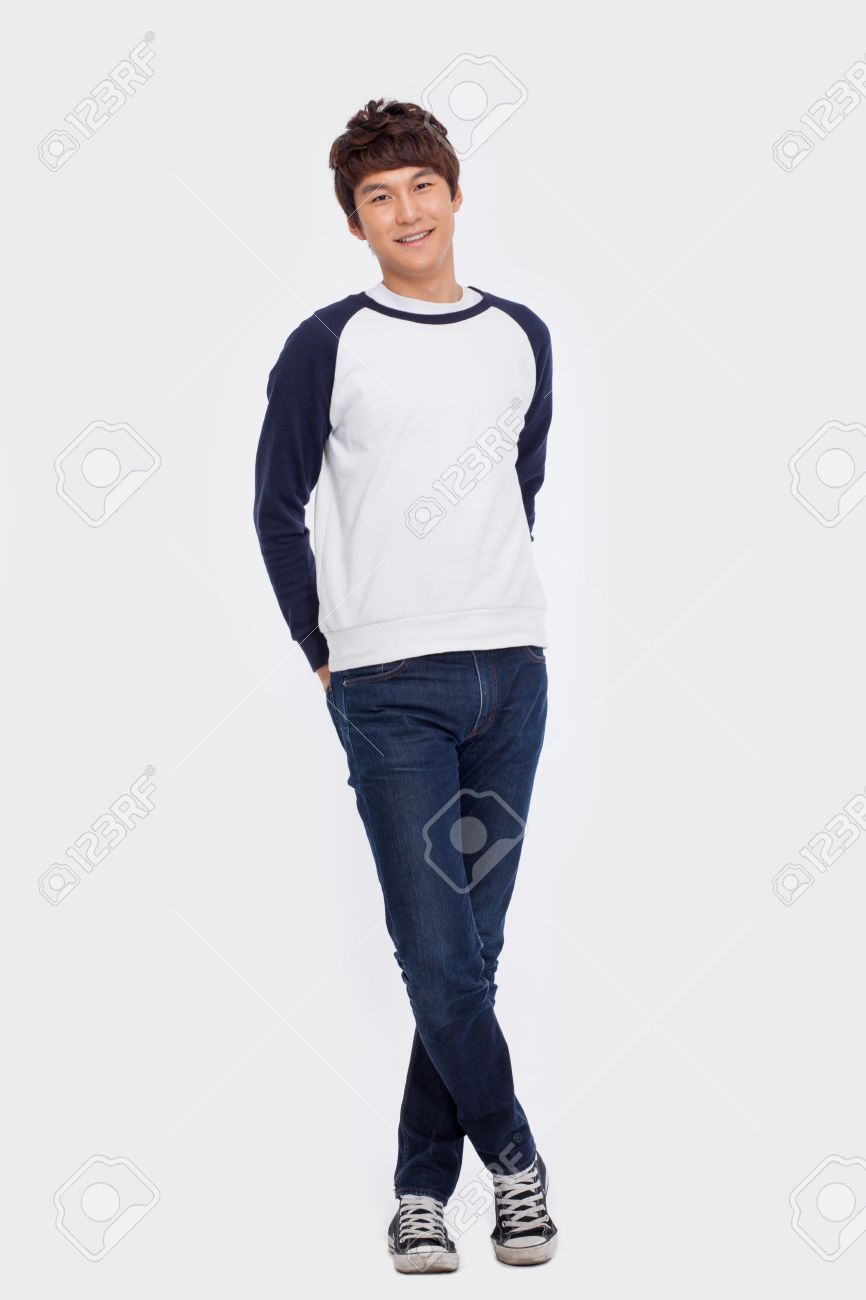

In [9]:
from IPython.display import Image

Image(f'images/{filename}.jpg',width=200,height=200)

In [10]:
img = cv2.imread(f'images/{filename}.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
# threshold to get just the signature (INVERTED)
retval, thresh_gray = cv2.threshold(gray, thresh=100, maxval=255,type=cv2.THRESH_BINARY_INV)
contours, hierarchy = cv2.findContours(thresh_gray,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
# Find object with the biggest bounding box
ind = 0
roi_list = []
for cont in contours:
    x,y,w,h = cv2.boundingRect(cont)
    if w > 50 and h > 50:
        roi=img[y:y+h,x:x+w]
        ind+=1
        roi_list.append(roi)
        cv2.imwrite(f'cropped/Image_crop{filename}-{ind}.jpg', roi)
        cv2.rectangle(img,(x,y),(x+w,y+h),(200,0,0),2)
cv2.imwrite(f'image_cont/Image_cont{filename}.jpg', img)

True

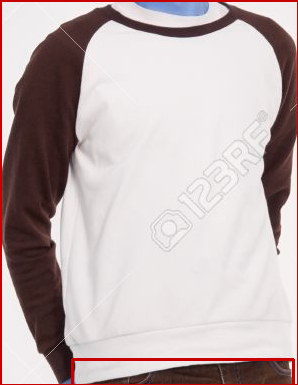

In [24]:
test = tf.keras.preprocessing.image.array_to_img(roi_list[2], data_format=None, scale=True, dtype=None)
test

In [25]:
custom_preds = model.predict(test)

ValueError: Failed to find data adapter that can handle input: <class 'PIL.Image.Image'>, <class 'NoneType'>

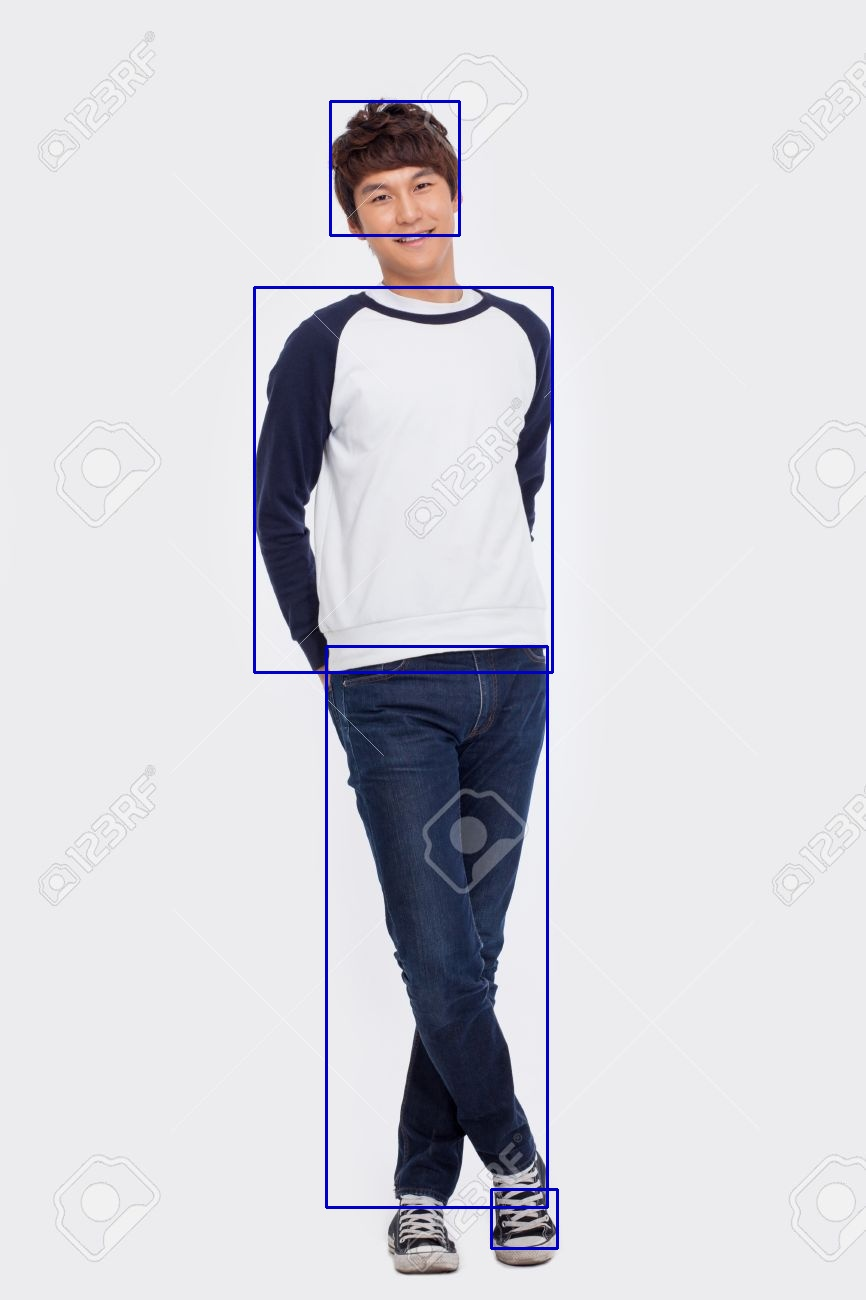

In [12]:
from IPython.display import Image

Image(f'image_cont/Image_cont{filename}.jpg',width=200,height=200)

In [27]:
type(custom_data)

tensorflow.python.data.ops.dataset_ops.BatchDataset

#### 4. Predict class of image

Creating testing data batches...
<TensorSliceDataset shapes: (), types: tf.string>
Tensor("convert_image:0", shape=(None, None, 3), dtype=float32)


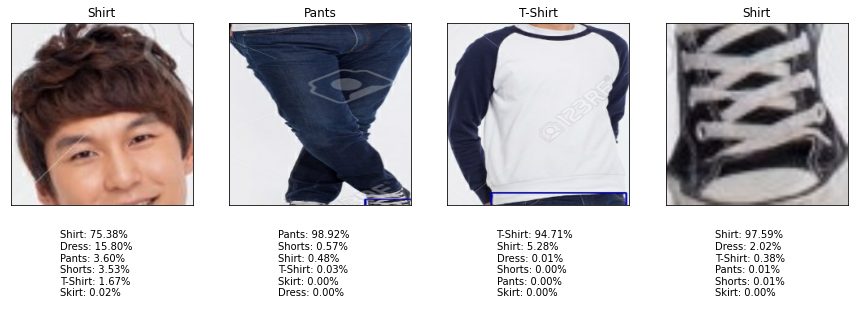

In [31]:
# Test the real images
predicted_list = []
custom_path= "cropped/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path) if fname !=".DS_Store"]
custom_data = create_data_batches(custom_image_paths,test_data=True)
custom_preds = model.predict(custom_data)
for preds in custom_preds:
    temp_list = []
    for i,pred in enumerate(preds,0): 
        temp_list.append([pred,apparel_list[i]])
    predicted_list.append(temp_list)
custom_preds_label = [apparel_list[np.argmax(cp)] for cp in custom_preds]
custom_images = []
for image in custom_data.unbatch().as_numpy_iterator():
    custom_images.append(image)
string_list = []
for preds in predicted_list:
    string = ""
    for pred in sorted(preds,reverse=True):
        string+= pred[1]+f": {pred[0]*100:.2f}%\n"
    string_list.append(string)
plt.figure(figsize=(15, 15))
for i, image in enumerate(custom_images):
    plt.subplot(1, len(custom_preds_label), i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(custom_preds_label[i])
    plt.text(60,350,s=string_list[i])
    plt.imshow(image)